In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv("dataset/ems_calls.csv")
df.head()

,ObjectId,eid,incident_num,typ_eng,sub_eng,first_dispo_code,first_dispo_eng,dispo_codes,dispo_descriptions,priority,call_datetime,city,neighborhood,ward,ward_2014,ward_2026,census_tract,zip,isDispatch,isTransport
0,1,7039593,E21039493,UNKNOWN PROBLEM (PERSON DOWN),LIFE STATUS QUESTIONABLE,RFAMA,REFUSED AMA - CONTACT RED CENTER CAPT.,RFAMA,REFUSED AMA - CONTACT RED CENTER CAPT.,2,2021/05/06 04:00:00+00,Cleveland,Lee-Harvard,Ward 1,Ward 1,Ward 1,Census Tract 1219,44128.0,True,False
1,2,7039690,E21039512,TRAFFIC / TRANSPORTATION INCIDENTS,UNKNOWN STATUS/OTHER CODES NOT APPLICABLE,RFSC,REFUSAL SPECIAL CIRCUMSTANCES - CONTACT RC CAPT.,RFSC,REFUSAL SPECIAL CIRCUMSTANCES - CONTACT RC CAPT.,4,2021/05/06 05:00:00+00,Cleveland,University,Ward 9,Ward 9,Ward 9,Census Tract 1188,44106.0,True,False
2,3,7039737,E21039519,OVERDOSE / POISONING (INGESTION),UNKNOWN STATUS/OTHER CODES NOT APPLICABLE,TRB,BRAVO TRANSPORT,TRB,BRAVO TRANSPORT,3,2021/05/06 07:00:00+00,Cleveland,Edgewater,Ward 15,Ward 15,Ward 12,Census Tract 1013,44102.0,True,True
3,4,7039767,E21039528,HEMORRHAGE / LACERATIONS,ABNORMAL BREATHING,TRC,CHARLIE TRANSPORT,TRC,CHARLIE TRANSPORT,2,2021/05/06 08:00:00+00,Cleveland,St.Clair-Superior,Ward 7,Ward 7,Ward 8,Census Tract 1989,44103.0,True,True
4,5,7039786,E21039533,TRAFFIC / TRANSPORTATION INCIDENTS,HIGH MECHANISM (K THROUGH T),NaN,NaN,NaN,NaN,2,2021/05/06 08:00:00+00,Cleveland,Kamm's,Ward 17,Ward 17,Ward 15,Census Tract 1232,44111.0,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502178 entries, 0 to 502177
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ObjectId            502178 non-null  int64  
 1   eid                 502178 non-null  int64  
 2   incident_num        502178 non-null  object 
 3   typ_eng             502064 non-null  object 
 4   sub_eng             469111 non-null  object 
 5   first_dispo_code    492668 non-null  object 
 6   first_dispo_eng     492668 non-null  object 
 7   dispo_codes         489784 non-null  object 
 8   dispo_descriptions  489051 non-null  object 
 9   priority            502178 non-null  int64  
 10  call_datetime       502178 non-null  object 
 11  city                501390 non-null  object 
 12  neighborhood        500814 non-null  object 
 13  ward                501081 non-null  object 
 14  ward_2014           501081 non-null  object 
 15  ward_2026           500990 non-nul

In [4]:
# Clean column names
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_", regex=False)
)

# Check missing values
df.isnull().sum().sort_values(ascending=False)

print(df['istransport'].value_counts(dropna=False))
print(df['istransport'].dtype)


istransport
True     305582
False    187086
NaN        9510
Name: count, dtype: int64
object


In [5]:
df['istransport'] = df['istransport'].astype(str).str.lower()

df['istransport'] = df['istransport'].map({
    'true': 1,
    'false': 0,
    '1': 1,
    '0': 0,
    'yes': 1,
    'no': 0
})

df = df.dropna(subset=['istransport'])
df['istransport'] = df['istransport'].astype(int)

# Convert datetime
df['call_datetime'] = pd.to_datetime(df['call_datetime'], errors='coerce')
df = df.dropna(subset=['call_datetime'])

# Fill numeric NaNs
df['priority'] = df['priority'].fillna(df['priority'].median())


In [6]:
df['hour'] = df['call_datetime'].dt.hour
df['day_of_week'] = df['call_datetime'].dt.dayofweek

features = ['priority', 'hour', 'day_of_week']
X = df[features]
y = df['istransport']

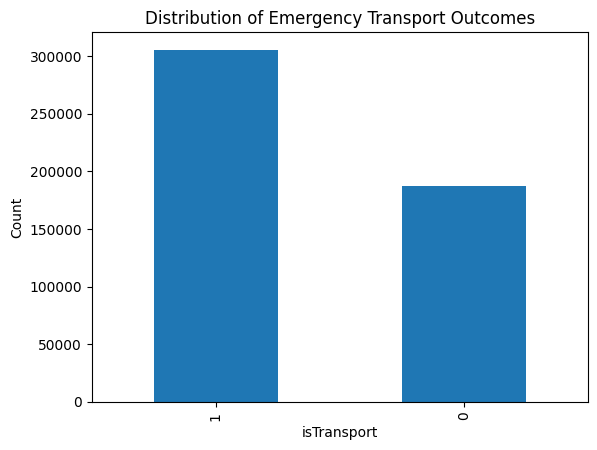

In [7]:
y.value_counts().plot(kind='bar')
plt.title("Distribution of Emergency Transport Outcomes")
plt.xlabel("isTransport")
plt.ylabel("Count")
plt.show()

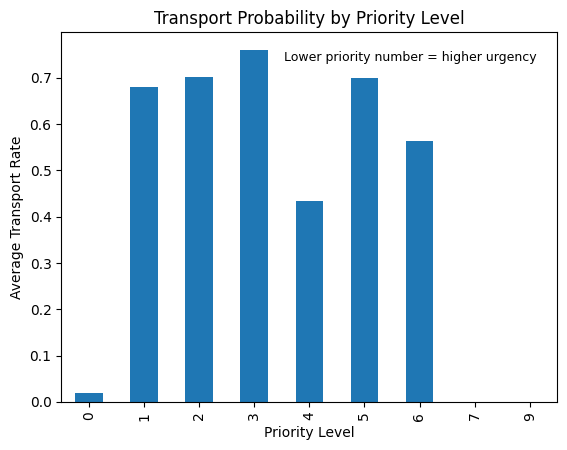

In [8]:
df.groupby('priority')['istransport'].mean().plot(kind='bar')

plt.title("Transport Probability by Priority Level")
plt.xlabel("Priority Level")
plt.ylabel("Average Transport Rate")

plt.text(
    0.45, 0.95,
    "Lower priority number = higher urgency",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha='left',
    va='top'
)

plt.show()

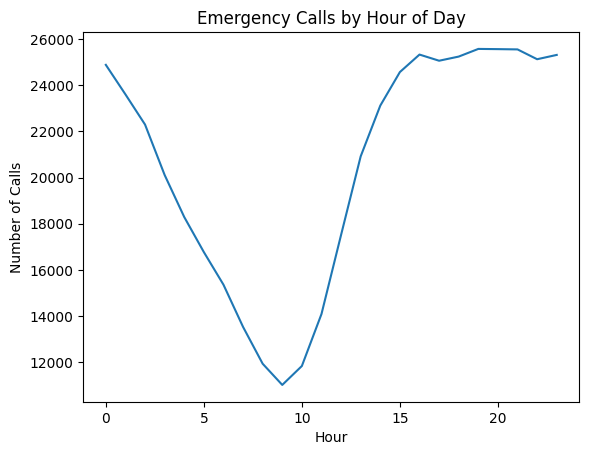

In [9]:
df['hour'].value_counts().sort_index().plot()
plt.title("Emergency Calls by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Calls")
plt.show()

In [10]:
df['istransport'] = df['istransport'].astype(int)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
log_model = LogisticRegression(max_iter=1000)

log_model.fit(X_train, y_train)

log_pred = log_model.predict(X_test)

log_accuracy = accuracy_score(y_test, log_pred)
log_precision = precision_score(y_test, log_pred)

print("Logistic Regression Accuracy:", log_accuracy)
print("Logistic Regression Precision:", log_precision)

Logistic Regression Accuracy: 0.6261594982442609
Logistic Regression Precision: 0.6476817959980479


In [13]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)

print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Precision:", rf_precision)

Random Forest Accuracy: 0.6971806686017009
Random Forest Precision: 0.7138276003837193


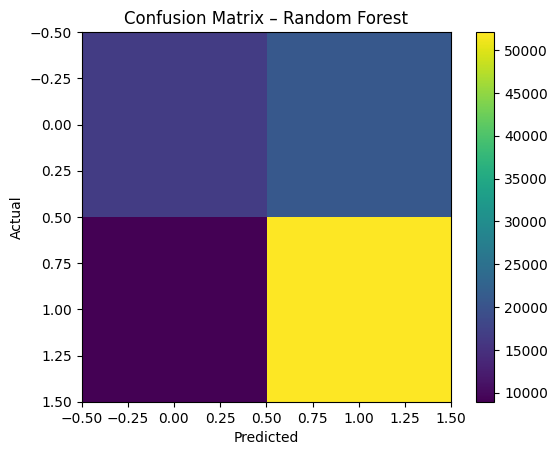

In [14]:

cm = confusion_matrix(y_test, rf_pred)

plt.imshow(cm)
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
svm_model = LinearSVC(max_iter=1000)

svm_model.fit(X_train_scaled, y_train)

svm_pred = svm_model.predict(X_test)

svm_accuracy = accuracy_score(y_test, svm_pred)
svm_precision = precision_score(y_test, svm_pred)

print("SVM Accuracy:", svm_accuracy)
print("SVM Precision:", svm_precision)


SVM Accuracy: 0.44446586964905516
SVM Precision: 0.7028505244192781


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


AI Application: EMS Transport Prediction

In [19]:
print("=== EMS Transport Prediction Application ===")

# User inputs
priority = int(input("Enter priority level (1–9): "))
hour = int(input("Enter hour of incident (0–23): "))
day = int(input("Enter day of week (0=Monday, 6=Sunday): "))

# Prepare input
user_input = [[priority, hour, day]]

# Prediction
prediction = rf_model.predict(user_input)[0]
probability = rf_model.predict_proba(user_input)[0][1]

# Output
print("\nPrediction Result:")
if prediction == 1:
    print("Transport REQUIRED")
else:
    print("Transport NOT required")

print(f"Transport Probability: {probability:.2f}")

=== EMS Transport Prediction Application ===

Prediction Result:
Transport REQUIRED
Transport Probability: 0.81


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
